In [ ]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO

### Observed mutations

In [2]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/external/CancerDataFromCampbell/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,tissue,Annot,Unnamed: 34,Unnamed: 35,is_nonsense".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)
ObsAll.head()

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0
2,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",AGTCCTGTAT,CCCTTTTCCT,0
3,BLCA,9078,T,C,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",TATCAACCAT,AACCTTCCCT,0
4,BLCA,9686,T,C,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",ACCAAATAAT,CAAGCACTGC,0


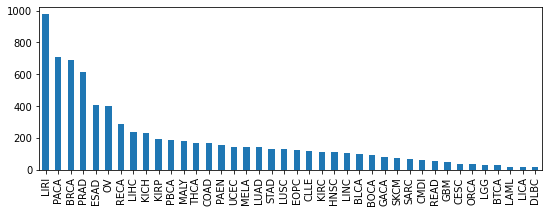

In [3]:
plt.figure(figsize=(9, 3))
ObsAll.tissue.value_counts().plot.bar();

In [4]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

### Extended annotation

In [5]:
path_to_ann = "../data/external/CancerDataFromCampbell/HumanMtDnaRefSeq.fasta.ExtensiveMut.vcf.ann"
_cols = [1, 3, 4, 7]
_names = ['position','ref','var','annotation']
ExtAnnRaw = pd.read_csv(
    path_to_ann, sep="\t", header=None, comment="#", usecols=_cols, 
    names=_names,
)
ExtAnnRaw["ProtCodGene"] = ExtAnnRaw["annotation"].apply(lambda x: x.split("|")[3])
ExtAnnRaw["SubstType"] = ExtAnnRaw["annotation"].apply(lambda x: x.split("|")[1])

In [6]:
set(ExtAnnRaw.position.value_counts().values)

{3, 6}

**Here error:** after and before positions are not sequential beacause one N

In [7]:
ExtAnn = ExtAnnRaw.copy()
After = ExtAnn.ref.iloc[3:].values
After = np.append(After, [None, None, None])
Before = ExtAnn.ref.iloc[:-3].values
_ = np.append(Before[::-1], [None, None, None])[::-1]
assert np.all(_[3:] == Before)
Before = _

ExtAnn["Before"] = Before
ExtAnn["After"] = After
ExtAnn["Context"] = ExtAnn["Before"] + ExtAnn["ref"] + ExtAnn["After"]
ExtAnn["Subst"] = ExtAnn["ref"] + ExtAnn["var"]
ExtAnn["Names"] = ExtAnn["Subst"] + ': ' + ExtAnn["Context"]
ExtAnn = ExtAnn.iloc[3:-3]
ExtAnn.head()

,position,ref,var,annotation,ProtCodGene,SubstType,Before,After,Context,Subst,Names
3,2,A,T,ANN=T|upstream_gene_variant|MODIFIER|ND1|MIM:5...,ND1,upstream_gene_variant,G,T,GAT,AT,AT: GAT
4,2,A,G,ANN=G|upstream_gene_variant|MODIFIER|ND1|MIM:5...,ND1,upstream_gene_variant,G,T,GAT,AG,AG: GAT
5,2,A,C,ANN=C|upstream_gene_variant|MODIFIER|ND1|MIM:5...,ND1,upstream_gene_variant,G,T,GAT,AC,AC: GAT
6,3,T,A,ANN=A|upstream_gene_variant|MODIFIER|ND1|MIM:5...,ND1,upstream_gene_variant,A,C,ATC,TA,TA: ATC
7,3,T,G,ANN=G|upstream_gene_variant|MODIFIER|ND1|MIM:5...,ND1,upstream_gene_variant,A,C,ATC,TG,TG: ATC


### Merge tables

In [8]:
# MERGE ObsAll & ExtAnn (all.x = TRUE)
print(ObsAll.shape)
ObsAllExt = pd.merge(ObsAll, ExtAnn, on=["position", "ref", "var"])
print(ObsAllExt.shape)
ObsAllExt = ObsAllExt.sort_values("position")
ObsAllExt = ObsAllExt[["tissue", "position", "Subst", "Names", "ProtCodGene", "SubstType"]]
print(ObsAllExt.shape)
ObsAllExt

(7611, 8)
(7611, 16)
(7611, 6)


,tissue,position,Subst,Names,ProtCodGene,SubstType
5086,MALY,35,GA,GA: GGG,ND1,upstream_gene_variant
4414,LIHC,39,CT,CT: GCT,ND1,upstream_gene_variant
618,BRCA,41,CT,CT: TCT,ND1,upstream_gene_variant
621,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant
620,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant
...,...,...,...,...,...,...
2753,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2752,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2751,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2750,KICH,16566,GA,GA: CGA,ND6,upstream_gene_variant


In [9]:
ObsAllExt[(ObsAllExt.position > 3100) & (ObsAllExt.position < 3110)]

,tissue,position,Subst,Names,ProtCodGene,SubstType
5436,OV,3104,TC,TC: CTA,ND1,upstream_gene_variant


In [10]:
ObsAllExt.SubstType.value_counts()

missense_variant                               3613
upstream_gene_variant                          2935
synonymous_variant                              805
stop_retained_variant                           121
stop_lost                                        55
stop_gained                                      52
start_lost                                       18
splice_region_variant&synonymous_variant         11
splice_region_variant&stop_retained_variant       1
Name: SubstType, dtype: int64

### "Expected" mutspec 

Reference genome doesn't contain state on 3107 position, it's N

In [11]:
def get_codon(pos):
    pic = (pos - 1) % 3
    start = pos - pic
    codon_df = Ref[Ref.position.isin(range(start, start + 3))]
    if len(codon_df) != 3:
        codon_str = None
    else:
        codon_str = "".join(codon_df.ref.values)
    return codon_str


def get_context(pos, l=1):
    context_df = Ref[Ref.position.isin(range(pos - l, pos + l + 1))]
    if len(context_df) != 3:
        context_str = None
    else:
        context_str = "".join(context_df.ref.values)    
    return context_str

def __prepare_codontable(codontable: Union[NCBICodonTableDNA, int]):
    if isinstance(codontable, NCBICodonTableDNA):
        pass
    elif isinstance(codontable, int):
        codontable = CodonTable.unambiguous_dna_by_id[codontable]
    else:
        ValueError("passed codontable is not appropriate")
    return codontable


def extract_syn_codons(codontable: Union[NCBICodonTableDNA, int]):
    """ extract synonymous (codons that mutate without amino acid change) 
    and fourfold codons from codon table

    return mapping[(cdn, pic)] of syn codons and set of ff codons
    """
    codontable = __prepare_codontable(codontable)
    aa2codons = defaultdict(set)
    for codon, aa in codontable.forward_table.items():
        aa2codons[aa].add(codon)

    syn_codons = defaultdict(int)
    for aa, codons in aa2codons.items():
        if len(codons) > 1:
            interim_dct = defaultdict(set)
            for i, slc in enumerate([slice(1, 3), slice(0, 3, 2), slice(0, 2)]):
                for codon in codons:
                    cdn_stump = codon[slc]
                    interim_dct[(cdn_stump, i)].add(codon)

            for key, aa_syn_codons in interim_dct.items():
                if len(aa_syn_codons) > 1:
                    pic = key[1]
                    for cdn in aa_syn_codons:
                        syn_codons[(cdn, pic)] += len(aa_syn_codons) - 1

    ff_codons = set()
    for (cdn, pic), num in syn_codons.items():
        if num == 3 and pic == 2:
            ff_codons.add(cdn)
    return dict(syn_codons), ff_codons


def is_syn_codons(codon1: str, codon2: str, codontable: Union[NCBICodonTableDNA, int]):
    """
    extract codons containing mutation that are synonymous

    return dict[codon: set[PosInCodon]]
    """
    if not isinstance(codon1, str) or not isinstance(codon2, str):
        return False
    codontable = __prepare_codontable(codontable)
    gc = codontable.forward_table
    return gc.get(codon1, "*") == gc.get(codon2, "*")


syn_codons, ff_codons = extract_syn_codons(2)

### Read reference genbank

In [12]:
def read_genbank_ref(path: str):
    gb_file = next(SeqIO.parse(path, "genbank"))
    ftypes_nc = {'rRNA', 'tRNA'}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    for ftr in gb_file.features:
        if ftr.type == "source":
            source = ftr.extract(gb_file)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.strand        
            if ftr.type == 'CDS' or ftr.type in ftypes_nc:
                df.at[pos, "GeneName"] = ftr.qualifiers["gene"][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)].GeneName.unique():
        gdf = df[df.GeneName == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            codon = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            codon = "".join(codon) if len(set(codon).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = codon
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df


In [13]:
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb)
print(Ref.shape)
Ref.to_csv("../data/processed/ref_annot.csv", index=None)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


In [14]:
Ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569 entries, 0 to 16568
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Pos         16569 non-null  int64 
 1   Nuc         16568 non-null  object
 2   Context     16564 non-null  object
 3   Strand      16569 non-null  int8  
 4   Type        16480 non-null  object
 5   GeneName    15358 non-null  object
 6   PosInGene   16569 non-null  int32 
 7   PosInCodon  16569 non-null  int8  
 8   Codon       10816 non-null  object
dtypes: int32(1), int64(1), int8(2), object(5)
memory usage: 873.9+ KB


In [15]:
# drop None from Context column
Ref.dropna(axis=0, subset=["Context"], inplace=True)

In [16]:
# abcent 3107 +- context pos
Ref.head(3110).tail(10)

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
3101,3102,T,ATC,1,rRNA,RNR2,-1,-1,NaN
3102,3103,C,TCT,1,rRNA,RNR2,-1,-1,NaN
3103,3104,T,CTA,1,rRNA,RNR2,-1,-1,NaN
3104,3105,A,TAC,1,rRNA,RNR2,-1,-1,NaN
3108,3109,T,TTC,1,rRNA,RNR2,-1,-1,NaN
3109,3110,C,TCA,1,rRNA,RNR2,-1,-1,NaN
3110,3111,A,CAA,1,rRNA,RNR2,-1,-1,NaN
3111,3112,A,AAA,1,rRNA,RNR2,-1,-1,NaN
3112,3113,A,AAT,1,rRNA,RNR2,-1,-1,NaN
3113,3114,T,ATT,1,rRNA,RNR2,-1,-1,NaN


### Merge tables again, but with ref annotation

In [17]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = list(ser["Subst"])
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon


ObsAllExtAnn = pd.merge(ObsAllExt, Ref, left_on="position", right_on="Pos")
ObsAllExtAnn["AltCodon"] = ObsAllExtAnn.apply(get_alt, axis=1)
ObsAllExtAnn["IsSyn"] = ObsAllExtAnn.apply(lambda s: is_syn_codons(s.Codon, s.AltCodon, 2), axis=1)
ObsAllExtAnn["IsFoufold"] = (ObsAllExtAnn["PosInCodon"] == 3) & ObsAllExtAnn["Codon"].isin(ff_codons)

ObsAllExtAnn.head()

,tissue,position,Subst,Names,ProtCodGene,SubstType,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,IsSyn,IsFoufold
0,MALY,35,GA,GA: GGG,ND1,upstream_gene_variant,35,G,GGG,-1,D-loop,NaN,-1,-1,NaN,None,False,False
1,LIHC,39,CT,CT: GCT,ND1,upstream_gene_variant,39,C,GCT,-1,D-loop,NaN,-1,-1,NaN,None,False,False
2,BRCA,41,CT,CT: TCT,ND1,upstream_gene_variant,41,C,TCT,-1,D-loop,NaN,-1,-1,NaN,None,False,False
3,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant,41,C,TCT,-1,D-loop,NaN,-1,-1,NaN,None,False,False
4,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant,41,C,TCT,-1,D-loop,NaN,-1,-1,NaN,None,False,False


In [18]:
assert np.all(ObsAllExtAnn.IsSyn | ObsAllExtAnn.IsFoufold == ObsAllExtAnn.IsSyn)

In [19]:
ObsAllExtAnn.IsFoufold.value_counts()

False    7149
True      462
Name: IsFoufold, dtype: int64

In [20]:
ObsAllExtAnn.IsSyn.value_counts()

False    6766
True      845
Name: IsSyn, dtype: int64

In [21]:
ObsAllExtAnn.SubstType.value_counts()

missense_variant                               3613
upstream_gene_variant                          2935
synonymous_variant                              805
stop_retained_variant                           121
stop_lost                                        55
stop_gained                                      52
start_lost                                       18
splice_region_variant&synonymous_variant         11
splice_region_variant&stop_retained_variant       1
Name: SubstType, dtype: int64

In [22]:
ObsAllExtAnn[(ObsAllExtAnn.SubstType == "stop_lost") & ObsAllExtAnn.IsSyn]

,tissue,position,Subst,Names,ProtCodGene,SubstType,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,IsSyn,IsFoufold
3088,OV,5921,AG,AG: GAC,COX1,stop_lost,5921,A,GAC,1,CDS,COX1,18,3,TGA,TGG,True,False
3109,MALY,5978,AG,AG: GAG,COX1,stop_lost,5978,A,GAG,1,CDS,COX1,75,3,TGA,TGG,True,False
3110,OV,5978,AG,AG: GAG,COX1,stop_lost,5978,A,GAG,1,CDS,COX1,75,3,TGA,TGG,True,False
3111,ESAD,5978,AG,AG: GAG,COX1,stop_lost,5978,A,GAG,1,CDS,COX1,75,3,TGA,TGG,True,False
4059,UCEC,8670,AG,AG: GAC,ATP6,stop_lost,8670,A,GAC,1,CDS,ATP6,144,3,TGA,TGG,True,False
4071,COAD,8730,AG,AG: GAT,ATP6,stop_lost,8730,A,GAT,1,CDS,ATP6,204,3,TGA,TGG,True,False
5352,LIRI,11923,AG,AG: GAT,ND4,stop_lost,11923,A,GAT,1,CDS,ND4,1164,3,TGA,TGG,True,False
5652,LIRI,12654,AG,AG: GAT,ND5,stop_lost,12654,A,GAT,1,CDS,ND5,318,3,TGA,TGG,True,False
5742,STAD,12810,AG,AG: GAT,ND5,stop_lost,12810,A,GAT,1,CDS,ND5,474,3,TGA,TGG,True,False
6088,EOPC,13557,AG,AG: GAG,ND5,stop_lost,13557,A,GAG,1,CDS,ND5,1221,3,TGA,TGG,True,False


## Merge only mutations and custom annotation from genbank

In [24]:
ObsAll.head(2)

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0


In [25]:
Ref.head(2)

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN


In [29]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon
    
ObsAllAnn = pd.merge(
    ObsAll[["tissue", "position", "ref", "var", "Annot", "is_nonsense"]], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
ObsAllAnn["AltCodon"] = ObsAllAnn.apply(get_alt, axis=1)
ObsAllAnn["IsSyn"] = ObsAllAnn.apply(lambda s: is_syn_codons(s.Codon, s.AltCodon, 2), axis=1)
ObsAllAnn["IsFoufold"] = (ObsAllAnn["PosInCodon"] == 3) & ObsAllAnn["Codon"].isin(ff_codons)

ObsAllAnn.head()

,tissue,position,ref,var,Annot,is_nonsense,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,IsSyn,IsFoufold
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,False,False
1,PAEN,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,False,False
2,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",0,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,True,True
3,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,False,False
4,LIRI,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,False,False


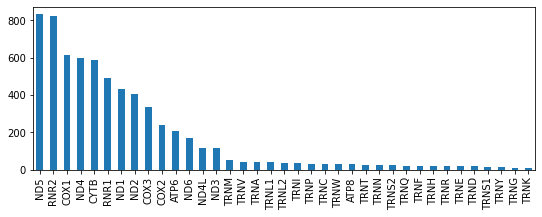

In [33]:
plt.figure(figsize=(9, 3))
ObsAllAnn.GeneName.value_counts().plot.bar();

In [35]:
ObsAllAnn["Mut"] = ObsAllAnn.Context.str.get(0) + "[" + ObsAllAnn["ref"] + ">" + ObsAllAnn["var"] + "]" + ObsAllAnn.Context.str.get(-1)

In [39]:
Mut = ObsAllAnn[["Pos", "Mut", "Strand", "GeneName", "tissue", "IsSyn", "IsFoufold"]]
Mut.head()

,Pos,Mut,Strand,GeneName,tissue,IsSyn,IsFoufold
0,2680,T[T>C]G,1,RNR2,BLCA,False,False
1,2680,T[T>C]G,1,RNR2,PAEN,False,False
2,6011,T[T>C]A,1,COX1,BLCA,True,True
3,7706,T[G>A]C,1,COX2,BLCA,False,False
4,7706,T[G>A]C,1,COX2,LIRI,False,False


In [44]:
Mut[(Mut.Strand == 1)].groupby("Mut").Pos.count()

Mut
A[A>C]C     14
A[A>C]G      1
A[A>C]T      1
A[A>G]A      8
A[A>G]C     71
          ... 
T[T>C]A     77
T[T>C]C    104
T[T>C]G     40
T[T>C]T     71
T[T>G]G      3
Name: Pos, Length: 158, dtype: int64

In [33]:
##### DEFINE MAIN SUBSETS OF MUTATIONS:
SubsetGenes = ['withoutNd6'] #  ['withNd6','withoutNd6','Nd6Only']
SubsetSubstitutions = ['synonymous','AllExceptStopGains'] #  ['synonymous','non-synonymous','SynAndNons']